In [1]:
import ironman
import numpy as np
import pandas as pd
from astropy import units as u
import matplotlib.pyplot as plt
import corner

In [2]:
#from matplotlib import rc                              Use only if you have pdflatex
#rc('font', **{'family':'sans-serif'})
#rc('text', usetex=True)

plt.rcParams['xtick.top'] =  True
plt.rcParams['xtick.direction'] =  'in'
plt.rcParams['xtick.major.width'] =  1.0
plt.rcParams['xtick.minor.width'] =  1.0
plt.rcParams['ytick.right'] =  True
plt.rcParams['ytick.direction'] =  'in'
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['ytick.minor.width'] =  1.0
plt.rcParams['lines.markeredgewidth'] =  1.0

In [3]:
tess = pd.read_csv('../../data/lcdata/TOI-2431_detrended.csv')
time_tess = tess.time.values
flux_tess = tess.flux.values
flux_err_tess = tess.flux_err.values

mask = np.isnan(flux_tess)                #There are np.nan in the data D:

time_tess = time_tess[~mask]
flux_tess = flux_tess[~mask]
flux_err_tess = flux_err_tess[~mask]

In [5]:
neid = pd.read_csv('../../data/rvdata/TIC 258804746_rv_bin_new.csv')
time_neid = neid['bjd'].values
rv_neid = neid['rv'].values
rv_err_neid = neid['e_rv'].values

In [6]:
times_lc, fluxes, fluxes_error = {}, {}, {}
times_rvs, rvs, rvs_err =  {}, {}, {}
times_RM, RM, RM_err =  {}, {}, {}

times_lc["TESS"], fluxes["TESS"], fluxes_error["TESS"] = time_tess, flux_tess, flux_err_tess

times_rvs["NEID"], rvs["NEID"], rvs_err["NEID"] = time_neid, rv_neid, rv_err_neid

exp = {"TESS": False}

In [7]:
data = ironman.DataOrganizer(output = "TOI-2431_ironman",lc_time=times_lc,lc_data=fluxes,lc_err=fluxes_error,rv_time=times_rvs,rv_data=rvs,rv_err=rvs_err,rm_time=times_RM,rm_data=RM,rm_err=RM_err,verbose = True,exp_times=exp)

Reading data...
Data Ready!
Data saved ...
exp_times saved ...


In [8]:
priors = ironman.Priors("../../data/lcrvpriors/priors_ironman.dat", data)

Priors dictionary ready...
Detecting fixed parameters...
Fixed e_p1 detected!
Fixed omega_p1 detected!
Fixed gammadot detected!
Fixed gammadotdot detected!
e, omega parametrization detected
Priors saved ...


In [9]:
fit = ironman.Fit(data = data, priors = priors)

The code is working with an eccentricity limit of 0.95
Fit class initialized.


In [10]:
postsamples = fit.run(n_live=500, nthreads = 30) #Increase the number of live points to e.g., 4500 and use the number of cores you are allowed to

Running dynesty with 500 nlive and 30 threads


24080it [15:46, 25.43it/s, batch: 4 | bound: 32 | nc: 1 | ncall: 695904 | eff(%):  3.387 | loglstar: 418197.683 < 418205.873 < 418203.568 | logz: 418176.293 +/-  0.178 | stop:  0.875]     


Saved fit results to TOI-2431_ironman/results.json
Saved posteriors to TOI-2431_ironman/posteriors.txt


In [11]:
fit = ironman.Fit(input="TOI-2431_ironman")

The code is working with an eccentricity limit of 0.95
e, omega parametrization detected
DataOrganizer and Priors initialized from input folder.
Loaded flatchain from TOI-2431_ironman/flatchain.csv
Loaded posteriors from TOI-2431_ironman/posteriors.txt
Fit class initialized.


In [12]:
results = ironman.Results(fit)

Results class initialized.


In [21]:
# Use the final values of R and M star
print(results.print_mass_radius_rho_sma_planet(rstar=0.66,rstar_err=0.01,mstar=0.66,mstar_err=0.02,r_units=u.Rearth,m_units=u.Mearth))

R_planet: 1.4966 +0.0725 -0.0432 earthRad
Sma_planet: 0.0068 +0.0005 -0.0009 AU
M_planet: 4.3573 +3.9390 -2.6990 earthMass
Rho_planet: 6.9671 +6.7227 -4.3821 g/cm^3
None


In [20]:
print(results.results)

{'logZ': 418176.3340218161, 'logZ_err': 0.15451329535132174, 'BIC': -836288.4867572675, 'AIC': -836389.7465440847, 'reduced_chi2': -11.37696545803864, 'n_eff': 3.3872365326401312}


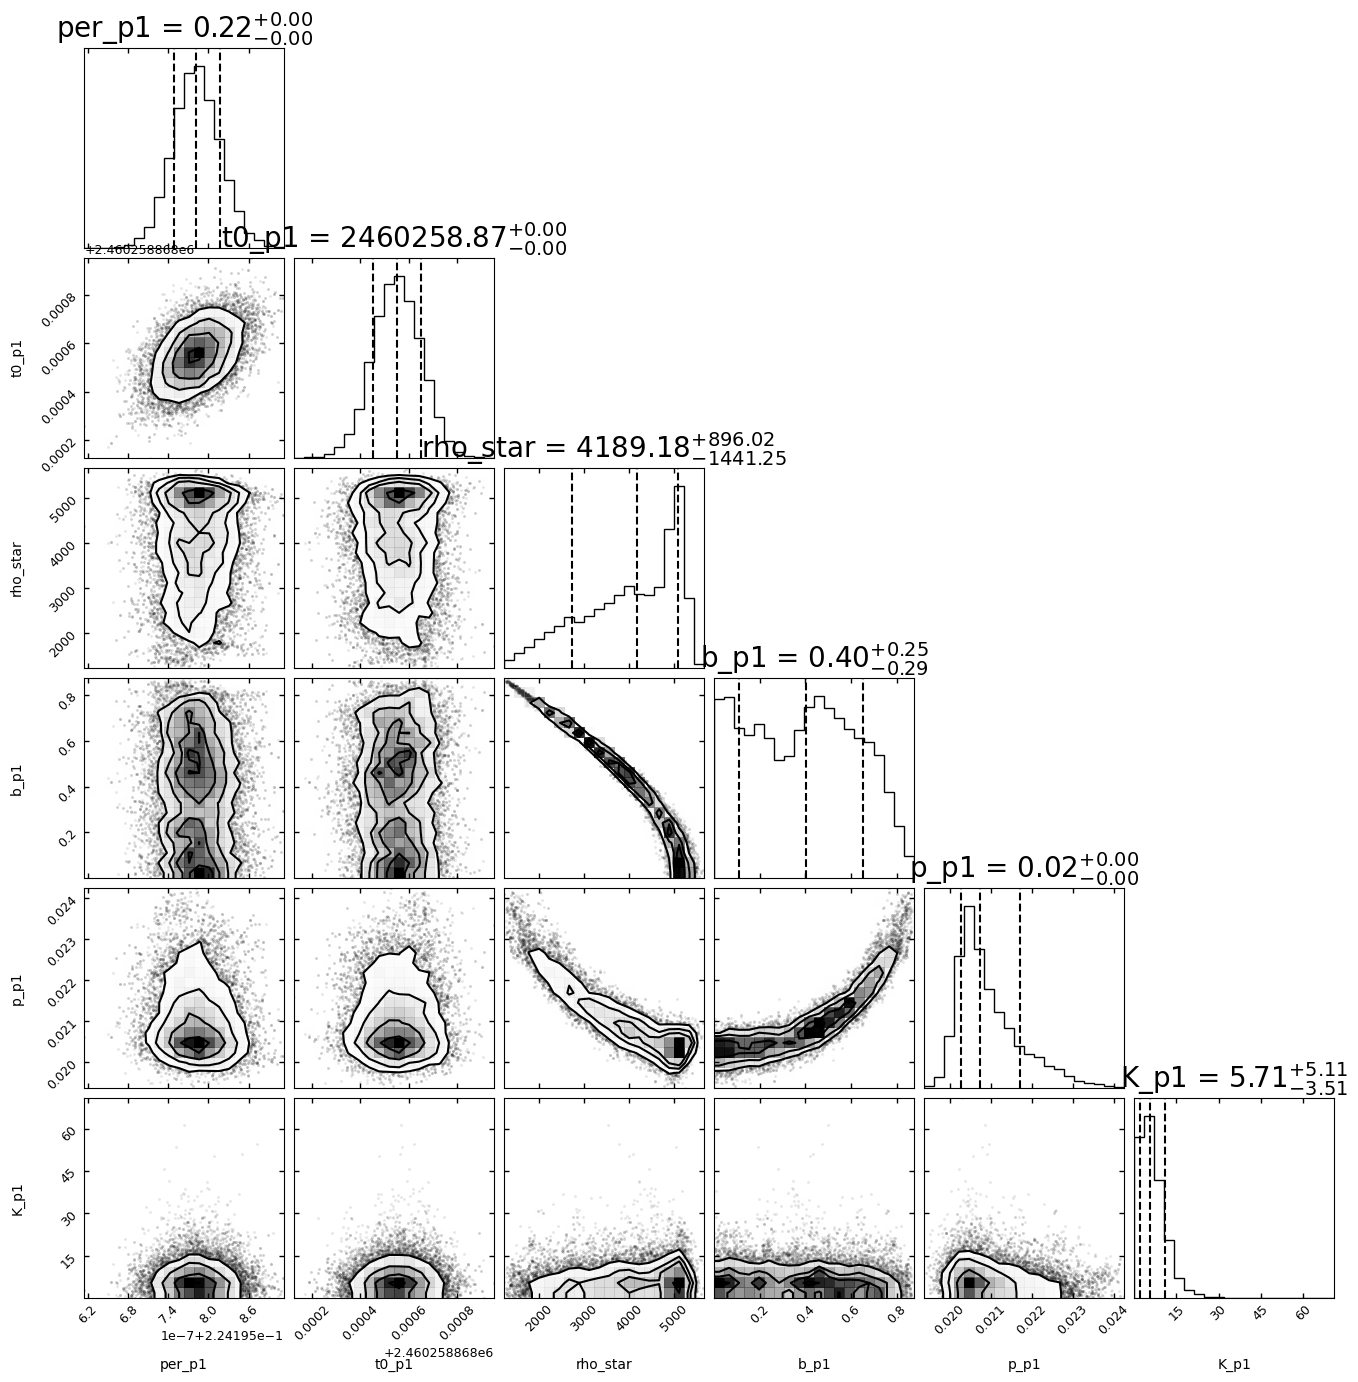

In [15]:
to_corner = results.chain[["per_p1", "t0_p1", "rho_star", "b_p1", "p_p1","K_p1"]]
corner.corner(to_corner.values,labels=to_corner.columns,quantiles=[0.16, 0.5, 0.84],label_kwargs={"fontsize": 10},
    show_titles=True,
    title_kwargs={"fontsize": 20})
plt.show()

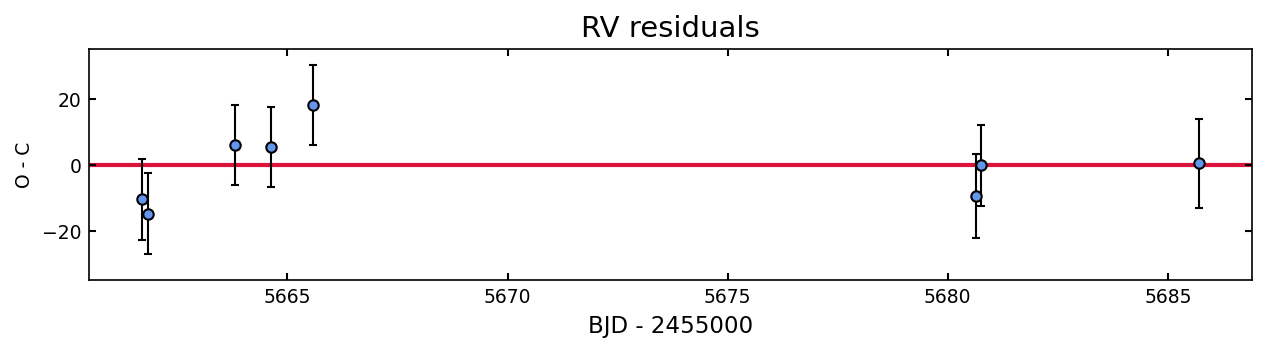

In [16]:
fig = plt.figure(figsize=(10,2),dpi=150)

t0 = results.vals["t0_p1"]
P = results.vals["per_p1"]

times_neid = results.data.x["NEID"]
times_models = times_neid
times_models = np.linspace(times_models.min(),times_models.max(),5000)

rv_models = results.evaluate_RV_model(times_models,"NEID",n_models=True,n=5000)
rv_model_neid = results.evaluate_RV_model(times_neid,"NEID")

jitter_neid = results.vals["sigma_NEID"]
data_neid, error_neid = results.data.y["NEID"], np.sqrt(results.data.yerr["NEID"]**2.0 + jitter_neid**2.0)

res_neid = data_neid-rv_model_neid

plt.errorbar(times_neid - 2455000,res_neid,error_neid,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="cornflowerblue")
plt.axhline(0.0,lw=2,color="crimson",zorder=-10)
plt.title("RV residuals", fontsize=14)
plt.xlabel(r'BJD - 2455000',fontsize=11)
plt.ylabel('O - C')
plt.ylim(-35,35)

fig.set_facecolor('w')
#fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3, fancybox=True, fontsize=12)
plt.show()
plt.savefig("TOI-2431b_rvresiduals.png", dpi = 500)
plt.close()

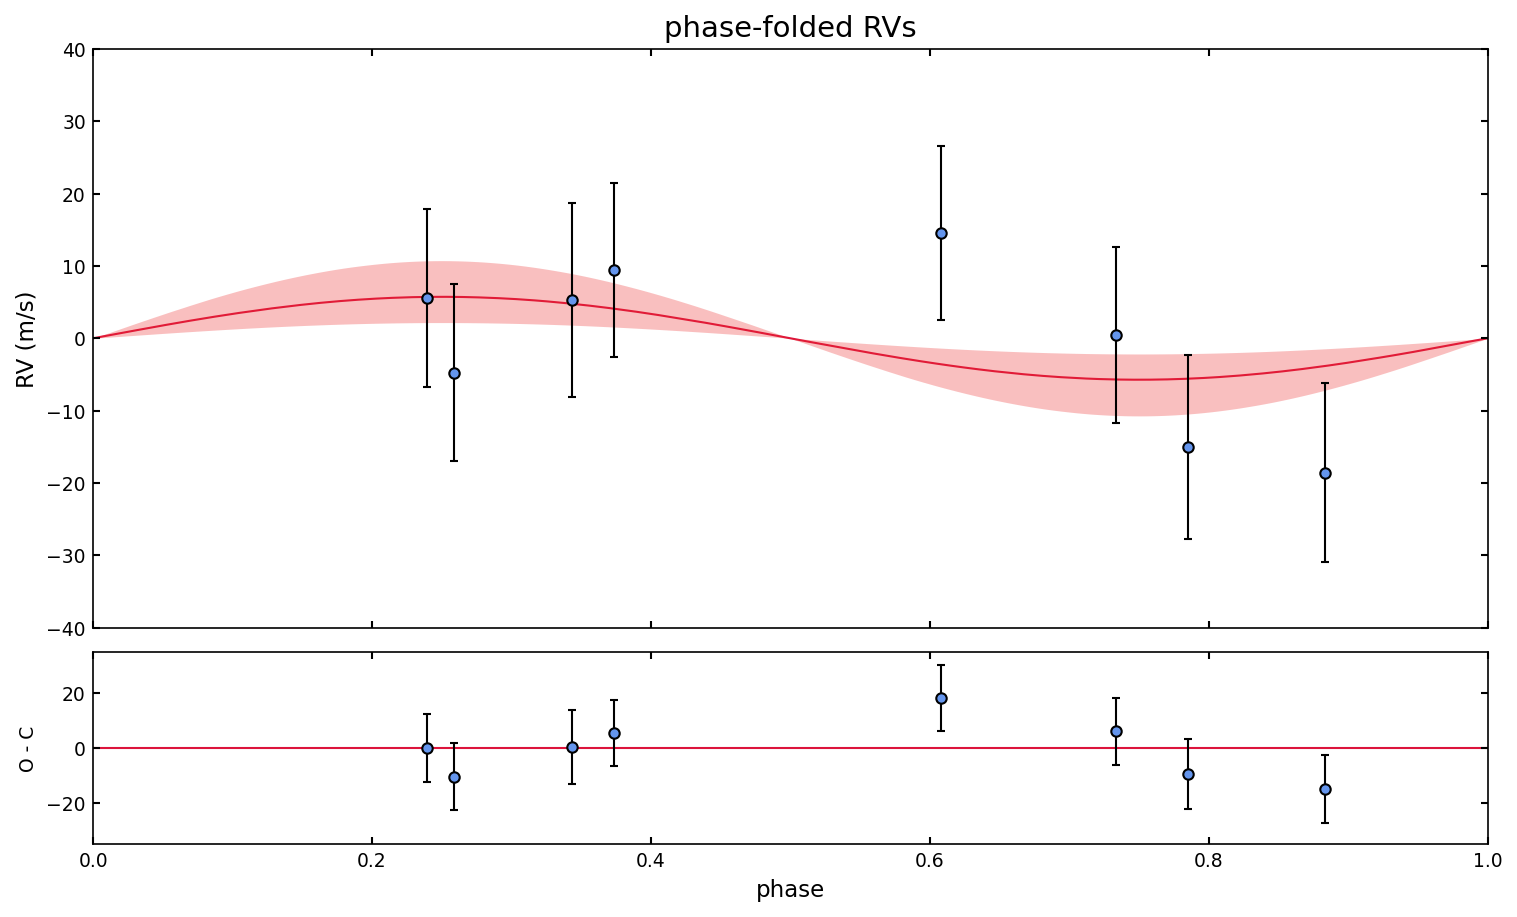

In [22]:
fig = plt.figure(figsize=(10,6),dpi=150,constrained_layout=True)
gs = fig.add_gridspec(4, 1)
ax1 = fig.add_subplot(gs[:3, 0])
ax2 = fig.add_subplot(gs[-1, 0], sharex = ax1)

phase_neid = ((times_neid-t0 + 0.5*P) % P)/P
phase_models = ((times_models-t0 + 0.5*P) % P)/P
idx = np.argsort(phase_models)

gamma_neid = results.vals["gamma_NEID"]

ax1.plot(phase_models[idx],np.quantile(rv_models,0.5,axis=0)[idx],lw=1.,color="crimson",zorder=-10)
ax1.fill_between(phase_models[idx],np.quantile(rv_models,0.16,axis=0)[idx],np.quantile(rv_models,0.84,axis=0)[idx],alpha=0.3,color="#EE2C2C",lw=0,zorder=-1) #1sigma models
#ax1.fill_between(phase_models[idx],np.quantile(rv_models,0.02,axis=0)[idx],np.quantile(rv_models,0.98,axis=0)[idx],alpha=0.2,color="#EE2C2C",lw=0,zorder=-1) #2sigma models
#ax1.fill_between(phase_models[idx],np.quantile(rv_models,0.0015,axis=0)[idx],np.quantile(rv_models,0.9985,axis=0)[idx],alpha=0.2,color="#EE2C2C",lw=0,zorder=-1) #3sigma models
ax1.errorbar(phase_neid,data_neid-gamma_neid,error_neid,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="cornflowerblue",label="NEID")

ax1.set_title("phase-folded RVs", fontsize=14)
ax1.set_ylabel('RV (m/s)',fontsize=11)
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylim(-40,40)
ax1.set_xlim(0,1)

ax2.errorbar(phase_neid,res_neid,error_neid,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="cornflowerblue")
ax2.axhline(0.0,lw=1.,color="crimson",zorder=-10)
ax2.set_xlabel(r'phase',fontsize=11)
ax2.set_ylabel('O - C')
ax2.set_ylim(-35,35)

fig.set_facecolor('w')
#fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3, fancybox=True, fontsize=12)
plt.show()
plt.savefig("TOI-2431b_rv.png", dpi = 500)
plt.close()

In [23]:
def bin_lc(phase, f, num_bins=40):
    # Generar los bordes de cada bin
    bin_edges = np.linspace(0.0, 1.0, num_bins + 1)
    # Calcular el centro de cada bin
    binned_phase = (bin_edges[:-1] + bin_edges[1:]) / 2
    binned_flux = []

    for i in range(num_bins):
        mask = (phase >= bin_edges[i]) & (phase < bin_edges[i + 1])
        if np.sum(mask) > 0:
            binned_flux.append(np.mean(f[mask]))
        else:
            binned_flux.append(np.nan)

    binned_flux = np.array(binned_flux)
    #print(len(binned_phase), len(binned_flux))
    return binned_phase, binned_flux

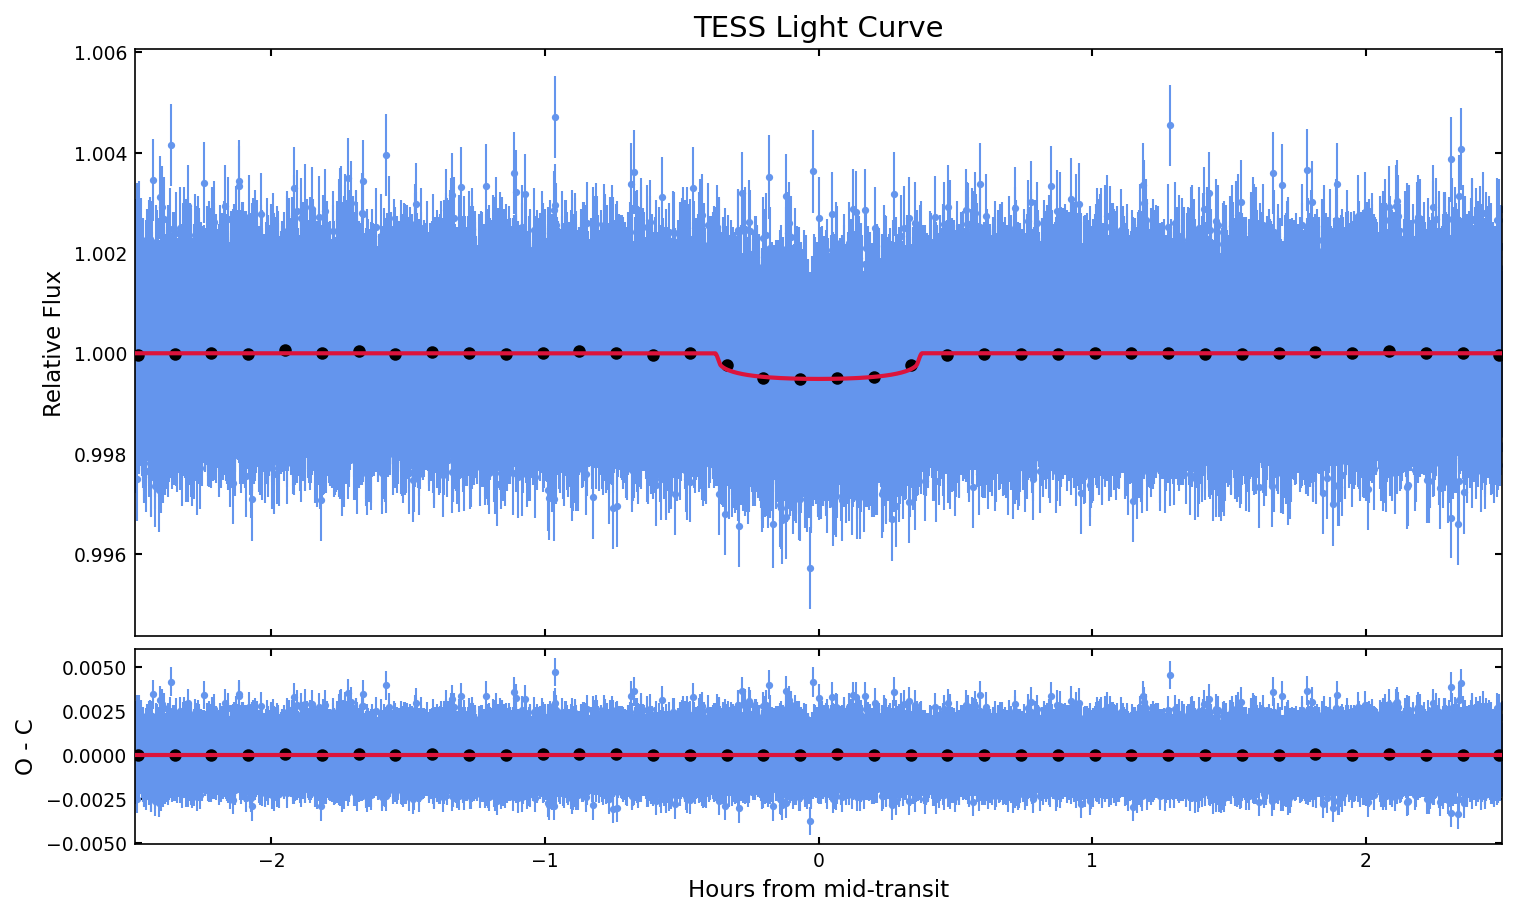

In [24]:
fig = plt.figure(figsize=(10,6),dpi=150,constrained_layout=True)
gs = fig.add_gridspec(4, 1)
ax1 = fig.add_subplot(gs[:3, 0])
ax2 = fig.add_subplot(gs[-1, 0], sharex = ax1)

times_TESS = results.data.x["TESS"]
lc_model_TESS = results.evaluate_LC_model(times_TESS,"TESS")
jitter_TESS = results.vals["sigma_TESS"]
phase_TESS = ((times_TESS-t0 + 0.5*P) % P)/P
idx = np.argsort(phase_TESS)
data_TESS, error_TESS = results.data.y["TESS"], np.sqrt(results.data.yerr["TESS"]**2.0 + jitter_TESS**2.0)

ax1.plot((phase_TESS[idx]-0.5)*P*24.,lc_model_TESS[idx],lw=2,color="crimson",zorder=10)
ax1.errorbar((phase_TESS-0.5)*P*24.,data_TESS,error_TESS,fmt=".",color="cornflowerblue",elinewidth=1)
#ax1.set_yticks([0.98,0.99,1,1.01])
ax1.set_xlim(-2.5,2.5)
ax1.set_xticks([-2,-1,0,1,2])
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel('Relative Flux',size=11)
ax1.set_title("TESS Light Curve",fontsize=14)

phase_bin, flux_bin = bin_lc(phase_TESS,data_TESS)
ax1.plot((phase_bin-0.5)*P*24.,flux_bin,"o",color="k",zorder=5)

res_TESS = data_TESS-lc_model_TESS
phase_res_bin, res_bin = bin_lc(phase_TESS,res_TESS)

ax2.errorbar((phase_TESS-0.5)*P*24.,res_TESS,error_TESS,fmt=".",color="cornflowerblue",elinewidth=1)
ax2.plot((phase_bin-0.5)*P*24.,res_bin,"o",color="k",zorder=5)
ax2.axhline(0.0,lw=2,color="crimson",zorder=10)

ax2.set_xlabel(r'Hours from mid-transit',size=11)
ax2.set_ylabel('O - C',size=11)

fig.set_facecolor('w')
plt.show()
plt.savefig("TOI-2431b_lightcurve.png", dpi = 500)
plt.close()